## Установка зависимостей

In [1]:
%pip install -r /kaggle/input/word-cloud-dataset/requirements.txt -q
%pip install natasha -q

ERROR: Could not find a version that satisfies the requirement pywin32==306 (from versions: none)
ERROR: No matching distribution found for pywin32==306
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Установка модулей

In [2]:
import nltk
nltk.download('brown')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package brown to /usr/share/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
from nltk.corpus import stopwords, brown
from nltk.tokenize import word_tokenize
import json
from natasha import MorphVocab, Doc, Segmenter, NewsMorphTagger, NewsEmbedding
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
import numpy as np
from tqdm import tqdm
from collections import defaultdict, Counter
from sklearn.cluster import AgglomerativeClustering, DBSCAN
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import time

## Предобработка

In [4]:
def dataset_to_text(dataset_path: str):
    with open(dataset_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
    texts = []
    for answer in data["answers"]:
        texts.extend(answer)
    return texts

def to_lowercase(sentence: str) -> str:
    return sentence.lower()

def remove_stopwords(sentence: str) -> str:
    # Получаем список стоп-слов для русского и английского языков
    stop_words_russian = set(stopwords.words('russian'))
    stop_words_english = set(stopwords.words('english'))
    
    # Объединяем два набора стоп-слов
    stop_words = stop_words_russian.union(stop_words_english)
    
    # Токенизируем предложение
    words = word_tokenize(sentence)
    
    # Фильтруем предложение, удаляя стоп-слова
    filtered_sentence = [word for word in words if word.lower() not in stop_words]
    
    return ' '.join(filtered_sentence)

segmenter = Segmenter()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
morph_vocab = MorphVocab()

def lemmatize(sentence: str) -> str:
    lemmatized = ''
    doc = Doc(sentence)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)
    for token in doc.tokens:
        token.lemmatize(morph_vocab)
        #print(token.text, token.lemma)
        lemmatized += token.lemma + ' '
    return lemmatized.strip()

## Работа с эмбеддингами

In [5]:
def get_word_embedding(word: str):
    inputs = tokenizer("clustering: " + word, return_tensors="pt", max_length=512, padding=True, truncation=True).to(device)  # Перемещаем входные данные на GPU
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0]

def normalize_embeddings(embedding):
    return F.normalize(embedding, p=2, dim=1)

def get_sentence_embedding(sentence: str):
    sentence_vector = normalize_embeddings(get_word_embedding(sentence)).cpu().numpy().reshape(-1)
    return sentence_vector

## Постобработка данных

In [6]:
def count_words_phrases(lemmatized_texts):
    word_count = Counter(lemmatized_texts)
    return dict(word_count)

def select_most_frequent_word(cluster_words, word_freq_dict, brown_freq):
    """
    Выбирает самое популярное слово в кластере, исходя из частоты встречаемости
    в текущем словаре word_freq_dict. При равной частоте использует частоту в языке (brown_freq).
    """
    sorted_words = sorted(
        cluster_words,
        key=lambda word: (-word_freq_dict[word], -brown_freq.get(word, 0))
    )
    return sorted_words[0]

# заменяем леммы в словаре на текст, который был в исходном датасете
def lemma_replacement(lemma: str, lemmatize_dict) -> str:
    if lemma in lemmatize_dict.keys():
        return lemmatize_dict[lemma]
    return lemma

def replace_keys_by_function(d, func, lemmatize_dict):
    return {func(k, lemmatize_dict): v for k, v in d.items()}

## Генерация облака слов

In [7]:
def generate_word_cloud(word_dict):
    # Создаем облако слов
    wordcloud = WordCloud(width=800, height=400, background_color='white', collocations=False).generate_from_frequencies(word_dict)

    # Отображаем облако слов
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Убираем оси
    plt.show()

## Замер времени

In [8]:
def time_of_function(function):
    def wrapped(*args, **kwargs):
        start_time = time.time()
        res = function(*args, **kwargs)
        print("Время выполнения:", round(time.time() - start_time, 2), "секунд")
        return res
    return wrapped

## Основная логика

In [9]:
@time_of_function
def get_word_distribution(texts: list[str], embedding_function, clustering_model) -> dict:
    
    texts = list(map(to_lowercase, texts))

    lemmatized_texts = []
    lemmatize_dict = {}

    for sentence in texts:
        lemmatized_sentence = lemmatize(remove_stopwords(sentence))
        lemmatize_dict[lemmatized_sentence] = sentence
        lemmatized_texts.append(lemmatized_sentence)

    lemmatized_texts = list(map(remove_stopwords, lemmatized_texts))

    word_freq_dict = count_words_phrases(lemmatized_texts)
    
    embeddings = []
    for sentence in tqdm(word_freq_dict.keys()):
        embeddings.append(get_sentence_embedding(sentence))

    embeddings = np.array(embeddings)

    labels = clustering_model.fit_predict(embeddings)

    # группировка слов по кластерам
    word_clusters = defaultdict(list)
    for word, label in zip(word_freq_dict.keys(), labels):
        word_clusters[label].append(word)

    brown_freq = Counter(brown.words())

    # формируем итоговый словарь: ключ — наиболее частое слово, значение — количество слов в кластере
    final_word_dict = {}
    for label, cluster_words in word_clusters.items():
        most_frequent_word = select_most_frequent_word(cluster_words, word_freq_dict, brown_freq)
        final_word_dict[most_frequent_word] = len(cluster_words)

    final_word_dict = replace_keys_by_function(final_word_dict, lemma_replacement, lemmatize_dict)

    return final_word_dict

# Запуск тестов производительности

In [10]:
DATASET_PATH = '/kaggle/input/word-cloud-dataset/'

small_datasets_texts = dataset_to_text(DATASET_PATH + 'small_dataset_20.json')
medium_datasets_texts = dataset_to_text(DATASET_PATH + 'medium_dataset_100.json')
medium_datasets_texts_2 = dataset_to_text(DATASET_PATH + 'medium_dataset_500.json')
big_datasets_texts = dataset_to_text(DATASET_PATH + 'big_dataset_1000.json')

## Параметры тестирования

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")

tokenizer = AutoTokenizer.from_pretrained("ai-forever/ru-en-RoSBERTa")
model = AutoModel.from_pretrained("ai-forever/ru-en-RoSBERTa").to(device)

agglomerative = AgglomerativeClustering(n_clusters=None, distance_threshold=1.5, linkage='ward')
dbscan = DBSCAN(eps=0.8, min_samples=1)

Используемое устройство: cuda


tokenizer_config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.49M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.82M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/5.99M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/958 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/715 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.61G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at ai-forever/ru-en-RoSBERTa and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Маленький датасет

100%|██████████| 72/72 [00:02<00:00, 33.96it/s]


Время выполнения: 6.78 секунд


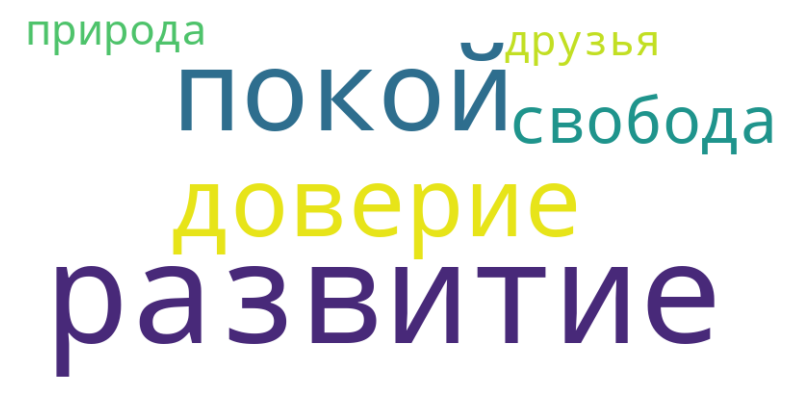

In [12]:
word_dict = get_word_distribution(small_datasets_texts, 
                                  embedding_function=get_sentence_embedding, 
                                  clustering_model=agglomerative
                                  )
generate_word_cloud(word_dict)

## Средний датасет 1

100%|██████████| 129/129 [00:02<00:00, 47.69it/s]


Время выполнения: 7.95 секунд


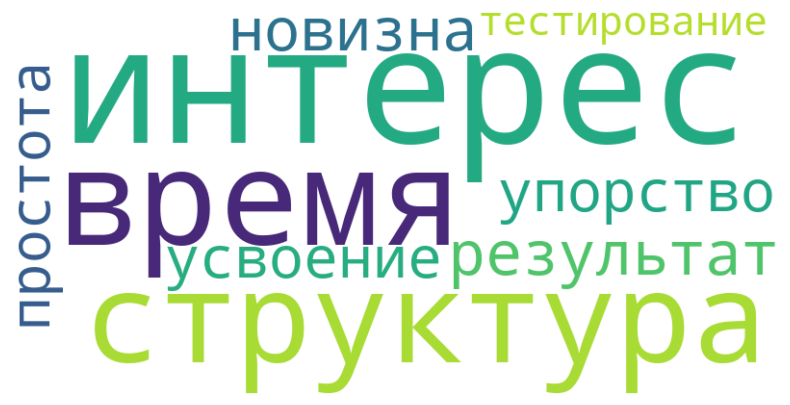

In [13]:
word_dict = get_word_distribution(medium_datasets_texts, 
                                  embedding_function=get_sentence_embedding, 
                                  clustering_model=agglomerative
                                  )
generate_word_cloud(word_dict)

## Средний датасет 2

100%|██████████| 593/593 [00:11<00:00, 51.18it/s]


Время выполнения: 22.84 секунд


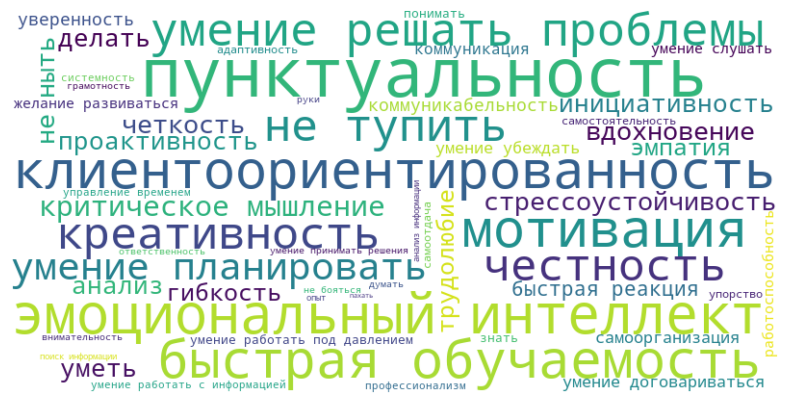

In [14]:
word_dict = get_word_distribution(medium_datasets_texts_2, 
                                  embedding_function=get_sentence_embedding, 
                                  clustering_model=agglomerative
                                  )
generate_word_cloud(word_dict)

## Большой датасет

100%|██████████| 814/814 [00:15<00:00, 51.81it/s]


Время выполнения: 34.01 секунд


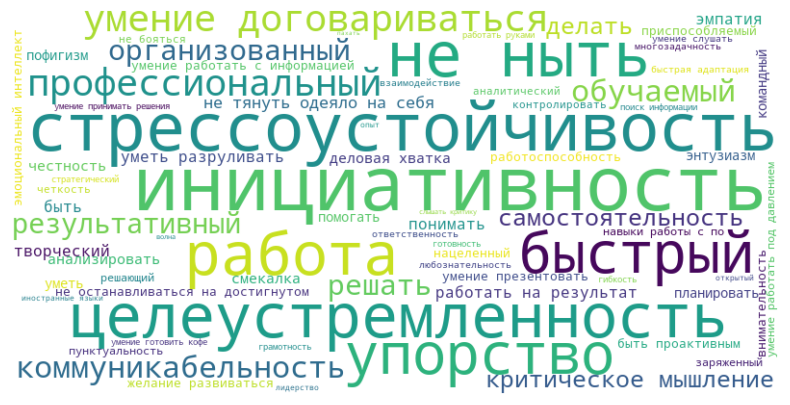

In [15]:
word_dict = get_word_distribution(big_datasets_texts, 
                                  embedding_function=get_sentence_embedding, 
                                  clustering_model=agglomerative
                                  )
generate_word_cloud(word_dict)